# Convert files

In [4]:
import surfradpy.mfr_raw2netcdf as mfr_r2nc

In [11]:
reload(mfr_r2nc)

<module 'surfradpy.mfr_raw2netcdf' from '/home/hagen/prog/SURFRAD/surfradpy/mfr_raw2netcdf.py'>

In [10]:
ci = mfr_r2nc.MfrsrRawToNetcdf('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}',
                      '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}.netcdf/v{version}/',
                      'frc_{serialnumber}_{year}{month}{day}.nc',
                      serialnumber = '648',)
ds = ci.process()

0
1
No rawfiles have been processe yet, start from the beginning
......

In [12]:
ci = mfr_r2nc.MfrsrRawToNetcdf('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}',
                      '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serialnumber}.netcdf/v{version}/',
                      'frc_{serialnumber}_{year}{month}{day}.nc',
                      serialnumber = '649',)
ds = ci.process()

1
No rawfiles have been processe yet, start from the beginning
.........

# Lets plots some 

In [17]:
ds = xr.open_mfdataset(pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.netcdf/v0.1').glob('*'))

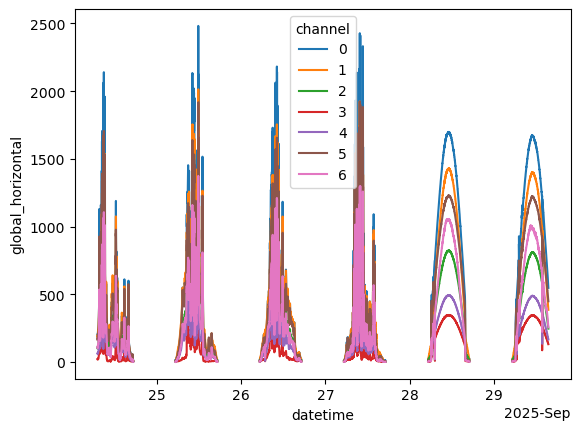

In [21]:
ds.global_horizontal.plot.line(x = 'datetime')